## imports

In [1]:
import numpy as np
from numpy import sqrt, abs, pi, exp, diag, mean, min, max, sum, eye
from numpy.linalg import norm, inv
import math
import matplotlib.pyplot as plt
import time

In [2]:
import torch

## function & derivatives

In [2]:
def elliptic(x):
    n = x.shape[0]
    d = x.shape[1]
    # n x d shape of x
    sum = 0
    for i in range(d):
        sum += (10**6)**(i/d) * x[:,i]**2
    return sum.astype('float32')


In [3]:
def elliptic_grad(x):
    n = x.shape[0]
    d = x.shape[1]
    # n x d shape of x
    gradf = np.zeros((n,d))
    for i in range(d):
        # sum += (10**6)**(i/d) * x[:,i]**2
        gradf[:,i] = 2 * (10**6)**(i/d) * x[:,i]

    return gradf.astype('float32')

## func, xmean, dim

In [4]:
N = 5000

strfitnessfct = elliptic
strgrad = elliptic_grad
xmean = 0.1*np.ones((N,1)) + 0.01* np.random.randn(N,1)

In [5]:
xmean.shape

(5000, 1)

## initialisations

In [6]:
stopfitness = 1e-3

In [7]:
xmean = xmean.astype('float32')
xmin = xmean

In [8]:
R = 0.1 * np.ones((1,N))
Γ = np.zeros((N,1), dtype = np.float32)
p = 5
cs = 0.1
it = 0
prev = 0
θ = 0.1
Δ = 0
x_st = xmean
fXX = (strfitnessfct(xmean.T))

## helper functions

In [9]:
def generate_arx(x, r, num = 5):
    return np.concatenate([x,x + (r * (2*np.random.rand(num-1, x.shape[0])-1)).T], axis = 1)

In [10]:
def sorted_x_y_grad(x, grads = True):
    if grads == True:
        y = strfitnessfct(x.T)
        y_grad = strgrad(x.T).T
        
        y_sorted = np.sort(y)
        sorted_indices = np.argsort(y)
        y_grad_sorted = y_grad[:,sorted_indices]
        x_sorted = x[:, sorted_indices]
        fittest = x_sorted[:,0:1]

        return x_sorted, y_sorted[0], y_grad_sorted, fittest
    else:
        y = strfitnessfct(x.T)
        y_sorted = np.sort(y)
        sorted_indices = np.argsort(y)
        x_sorted = x[:, sorted_indices]
        fittest = x_sorted[:,0:1]
        worst = x_sorted[:,-1:]

        return fittest, worst, y_sorted[0]

In [11]:
def calc_invH(x, x_grad, γ = 1):
    a = x - np.mean(x, axis = 1).reshape(-1,1)
    b = x_grad - np.mean(x_grad, axis = 1).reshape(-1,1)
    c = np.sum(a*b, axis = 1)
    d = np.sum(b*b, axis = 1)
    Hinv = (c / d).reshape(-1,1)
    Hinv = np.nan_to_num(Hinv)
    Hinv[Hinv<0] = 0.0
    return Hinv**γ

In [12]:
def cal_R(xmin, xmax, ps, cs = 0.1):
    ps = (1 - cs) * ps + cs * (xmax - xmin)
    sig = np.minimum(np.abs(ps.T), 0.01 * np.ones_like(ps.T))
    sig[sig == 0] = 0.01
    return sig, ps

In [13]:
def update_ensemble(x, α, Δ):
    K = Δ
    x1 = x - α * Δ
    return x1, K

In [14]:
def increment(K, B, G, θ=0.1):
    return θ * K + B * G

In [15]:
def wolfe_step(g, Hg, x, loss):
    
    step = 0.1
    c_1 = 0.001
    pvec = - Hg#/ torch.norm(Hg)
    γ = 1.0
    
    while γ > 1e-6:
        new_x = x.reshape(-1,1) + γ * pvec.reshape(-1,1)
        loss_new = strfitnessfct(new_x.T)
        g_new = strgrad(new_x.T)
        min_loss = c_1 * γ * pvec @ g
        armijo = loss_new - loss - min_loss

        if armijo < -0:
            step = γ
            x = new_x.reshape(-1,1)
            break
            
        else:
            γ *= 0.5
        # raise RuntimeError("Backtracking line search failed to converge")

    return step

# FINDER

In [16]:
tic = time.time()
while True:
    
    '''
    sampling around xmean
    '''
    arx = generate_arx(xmin, R)
    '''
    gradient computation and sorting initial ensemble
    '''
    arx_sorted, least_fitness, gradf_sorted, xmiin = sorted_x_y_grad(arx, grads=True)
    
    '''
    diagonal approximation to the stochastic mimic of the inverse Hessian
    '''
    B = calc_invH(arx_sorted, gradf_sorted)
    
    '''
    increment term
    '''
    Δ_sorted = increment(prev, B, gradf_sorted, θ)

    '''
    update ensemble
    '''
    α = wolfe_step(gradf_sorted[:, 0], Δ_sorted[:,0], arx_sorted[:, 0], least_fitness)
    arx_new, prev = update_ensemble(arx_sorted, α, Δ_sorted)
    
    '''
    new ensemble
    '''
    arx_new1 = np.concatenate([arx_new, xmiin], axis = 1)
    
    '''
    search radius update
    '''
    xmin, xmax, min_fitness = sorted_x_y_grad(arx_new1, grads=False)
    R, Γ = cal_R(xmin, xmax, Γ)
    
    '''
    storing varibales for plotting
    '''
    x_st = np.concatenate([x_st, xmin], axis = 1)
    fXX = np.concatenate([fXX, np.array([min_fitness])], axis = 0)
    
    '''
    iteration count update and printing
    '''
    if it == 0:
        print(it, "\t", fXX[it],"\n")
    it += 1
    print(it,"\t", fXX[it],"\n")
    
    '''
    termination criteria
    '''
    if fXX[-1] <= stopfitness:
        break
toc = time.time()
print("finished training in ",toc-tic," seconds")

0 	 3632465.5 

1 	 1.3582753e-08 

finished training in  0.049568891525268555  seconds


# Adam

In [17]:
from numpy.random import rand
from numpy import sqrt
# xx_st = xmean
fx_st = []
def adam(objective, n_iter, alpha, beta1 = 0.9, beta2 = 0.999, eps=1e-8):
    # generate an initial point
    global xx_st
    xx_st = xmean

    x = xmean.copy()  # Initialize with random values
    score = objective(x.T)
    # initialize first and second moments
    m = [0.0 for _ in range(len(x))]
    v = [0.0 for _ in range(len(x))]
    # run the gradient descent updates
    for t in range(n_iter):
        # calculate gradient g(t)
        g = strgrad(x.T)
        g = g.T
        # build a solution one variable at a time
        
        for i in range(len(x)):
            # m(t) = beta1 * m(t-1) + (1 - beta1) * g(t)
            m[i] = beta1 * m[i] + (1.0 - beta1) * g[i]
            # v(t) = beta2 * v(t-1) + (1 - beta2) * g(t)^2
            v[i] = beta2 * v[i] + (1.0 - beta2) * g[i]**2
            # mhat(t) = m(t) / (1 - beta1(t))
            mhat = m[i] / (1.0 - beta1**(t+1))
            # vhat(t) = v(t) / (1 - beta2(t))
            vhat = v[i] / (1.0 - beta2**(t+1))
            # x(t) = x(t-1) - alpha * mhat(t) / (sqrt(vhat(t)) + eps)
            x[i] = x[i] - alpha * mhat / (sqrt(vhat) + eps)
        # evaluate candidate point
        score = strfitnessfct(x.T)
        fx_st.append(score)
        xx_st = np.concatenate([xx_st, x], axis = 1)
        # report progress
        print('>%d f() = %.5f' % (t, score))
        if score < 1e-3:
            print("------")
            break
    
    return [x, score, xx_st]


In [18]:
tic = time.time()
_, f, xx_st_001 = adam(elliptic, 2000, 1e-3)
toc = time.time()
print(toc - tic)

/tmp/ipykernel_3569735/60144132.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('>%d f() = %.5f' % (t, score))


>0 f() = 3560735.75000
>1 f() = 3489749.75000
>2 f() = 3419518.00000
>3 f() = 3350053.25000
>4 f() = 3281364.75000
>5 f() = 3213470.50000
>6 f() = 3146372.25000
>7 f() = 3080087.75000
>8 f() = 3014620.25000
>9 f() = 2949980.25000
>10 f() = 2886178.25000
>11 f() = 2823219.00000
>12 f() = 2761115.25000
>13 f() = 2699863.75000
>14 f() = 2639477.50000
>15 f() = 2579961.00000
>16 f() = 2521315.00000
>17 f() = 2463545.50000
>18 f() = 2406655.75000
>19 f() = 2350645.75000
>20 f() = 2295518.50000
>21 f() = 2241278.00000
>22 f() = 2187918.50000
>23 f() = 2135444.25000
>24 f() = 2083851.75000
>25 f() = 2033140.12500
>26 f() = 1983309.00000
>27 f() = 1934354.75000
>28 f() = 1886273.75000
>29 f() = 1839061.75000
>30 f() = 1792715.25000
>31 f() = 1747229.50000
>32 f() = 1702599.37500
>33 f() = 1658817.62500
>34 f() = 1615882.37500
>35 f() = 1573784.12500
>36 f() = 1532515.12500
>37 f() = 1492072.25000
>38 f() = 1452442.75000
>39 f() = 1413625.50000
>40 f() = 1375606.75000
>41 f() = 1338381.37500
>4

# plotting

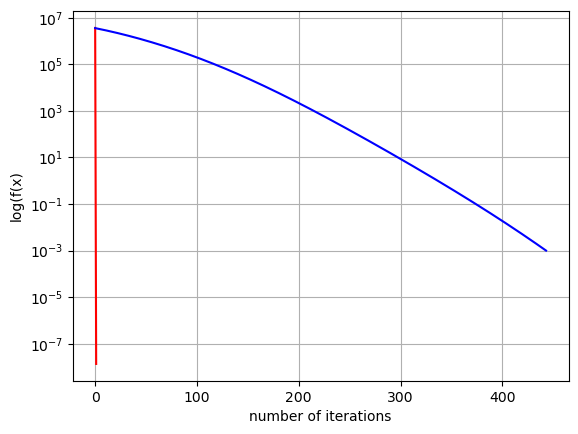

In [19]:
plt.style.use('default')
plt.plot(fXX, 'r', label = 'FINDER')
plt.plot(fx_st,'b', label = 'Adam')
plt.yscale('log')
plt.xlabel("number of iterations")
plt.ylabel("log(f(x)")
plt.grid()
plt.show()